In [1]:
import numpy as np
import dedalus.public as d3
from dedalus.tools.parallel import Sync
import h5py

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

import time
import logging
logger = logging.getLogger(__name__)

In [2]:
# Numerics Parameters
Nth, Nr = 128, 64
dtype = np.float64

R = 3*2*np.pi

dealias = 3/2
stop_sim_time = 40
timestepper = d3.RK443
dtype = np.float64

#Physics
Rosswave_k = 1.6

In [3]:
# Bases
coords = d3.PolarCoordinates('th', 'r')
dist = d3.Distributor(coords, dtype=dtype)
disk = d3.DiskBasis(coords, shape=(Nth, Nr), radius=R, dealias=dealias, dtype=dtype)
edge = disk.edge
(th,r)= dist.local_grids(disk) 

# Fields
q = dist.Field(bases=disk)
q_IC = dist.Field(bases=disk)
psi = dist.Field(bases=disk)
tau_psi = dist.Field(bases=edge)
tau_z = dist.Field(bases=edge)

beta = dist.Field(bases=disk)
beta['g'] = r*np.sin(th)

# wstr = dist.Field(bases=disk)
# wstr['g'] = -np.sin(4*np.pi*r*np.sin(th))

# Substitutions
lift = lambda A: d3.Lift(A, disk, -1)
grad = lambda A: d3.Gradient(A)
integ = lambda A: d3.Integrate(A, ('r', 'th'))

KE = d3.integ(grad(psi)@grad(psi))/2
# Enstrophy = d3.integ((q)**2)/2

In [4]:
# Problem
problem = d3.IVP([q, psi, tau_psi], namespace=locals())
problem.add_equation("lap(psi) - psi + lift(tau_psi) = q")
problem.add_equation("dt(q) = - skew(grad(psi))@grad(beta)")
problem.add_equation("psi(r=R) = 0")

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2024-04-18 12:00:37,215 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 9s, Rate: 6.8e+00/s
2024-04-18 12:00:37,391 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 3s, Rate: 2.2e+01/s
2024-04-18 12:00:37,582 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 1s, Remaining: 2s, Rate: 2.7e+01/s
2024-04-18 12:00:37,755 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.1e+01/s
2024-04-18 12:00:37,919 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.3e+01/s
2024-04-18 12:00:38,087 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 1s, Remaining: 1s, Rate: 3.4e+01/s
2024-04-18 12:00:38,240 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s
2024-04-18 12:00:38,390 subsystems 0/1 INFO :: Building subproblem matri

In [5]:
# zeta['g'] = np.exp(-(r*15)**2)*np.sin(r*np.cos(th))*1e-0 
q['g'] = np.exp(-(r/5)**2)*np.sin(r*np.cos(th)*Rosswave_k)

q_IC['g'] = q['g']
r_mat, theta_mat = np.meshgrid(th, r)

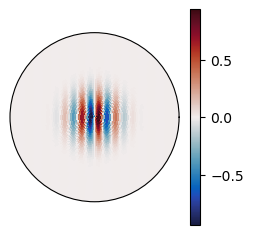

In [6]:
fig = plt.figure(figsize=(15/2.5, 7/2.5))

ax = fig.add_subplot(121, polar=True); ax.grid(False); plt.xticks([]); plt.yticks([]) 
pc = ax.pcolormesh(th.T,r.T,q['g'].T, cmap=cmo.balance, norm=colors.CenteredNorm())
# pc = ax.contour(r_mat,theta_mat,zeta_IC['g'].T,[-0.6,-0.2,0.2,0.6], colors='black')
fig.colorbar(pc)

In [7]:
# Analysis
snapdata = solver.evaluator.add_file_handler('Gyre_waves_snap', sim_dt=10, max_writes=35)
snapdata.add_task(-(-q), name='q')
snapdata.add_task(-(-psi), name='PSI')
snapdata.add_task(-(-beta), name='BETA')

diagdata = solver.evaluator.add_file_handler('Gyre_waves_diag', sim_dt=1, max_writes=200)

# Flow properties
dt_change_freq = 10
flow = d3.GlobalFlowProperty(solver, cadence=dt_change_freq)
flow.add_property(grad(psi)@grad(psi), name='absuv')
flow.add_property(grad(psi)@grad(psi)/2, name='KE')

2024-04-18 12:00:38,921 __main__ 0/1 INFO :: Starting main loop
2024-04-18 12:00:42,118 __main__ 0/1 INFO :: Iteration=2, Time=0.314, dt=1.571e-01, KE=0.000e+00


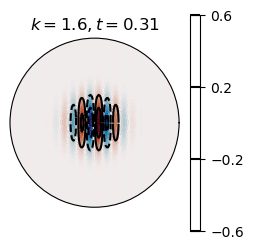

2024-04-18 12:00:42,960 __main__ 0/1 INFO :: Iteration=4, Time=0.628, dt=1.571e-01, KE=0.000e+00


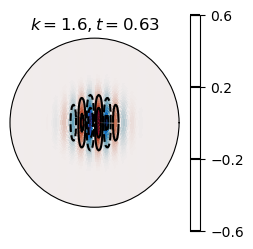

2024-04-18 12:00:43,554 __main__ 0/1 INFO :: Iteration=6, Time=0.942, dt=1.571e-01, KE=0.000e+00


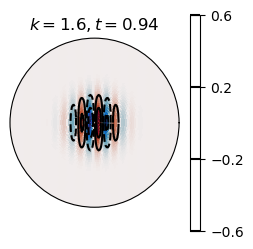

2024-04-18 12:00:44,336 __main__ 0/1 INFO :: Iteration=8, Time=1.257, dt=1.571e-01, KE=0.000e+00


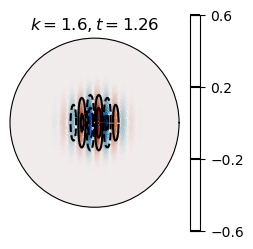

2024-04-18 12:00:45,077 __main__ 0/1 INFO :: Iteration=10, Time=1.571, dt=1.571e-01, KE=0.000e+00


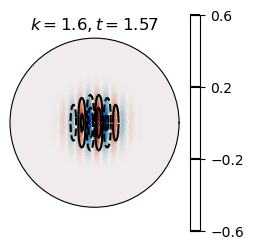

2024-04-18 12:00:45,749 __main__ 0/1 INFO :: Iteration=12, Time=1.885, dt=1.571e-01, KE=1.990e+00


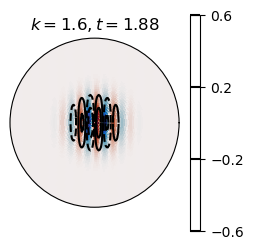

2024-04-18 12:00:46,362 __main__ 0/1 INFO :: Iteration=14, Time=2.199, dt=1.571e-01, KE=1.990e+00


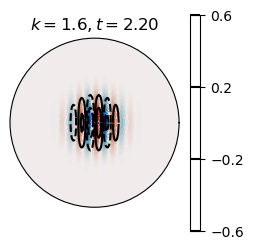

2024-04-18 12:00:46,944 __main__ 0/1 INFO :: Iteration=16, Time=2.513, dt=1.571e-01, KE=1.990e+00


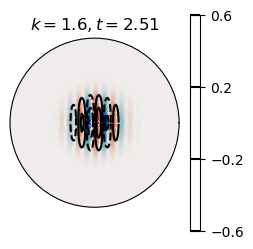

2024-04-18 12:00:47,478 __main__ 0/1 INFO :: Iteration=18, Time=2.827, dt=1.571e-01, KE=1.990e+00


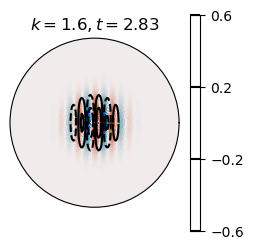

2024-04-18 12:00:48,160 __main__ 0/1 INFO :: Iteration=20, Time=3.142, dt=1.571e-01, KE=1.990e+00


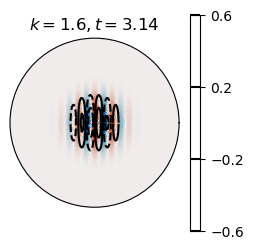

2024-04-18 12:00:48,860 __main__ 0/1 INFO :: Iteration=22, Time=3.456, dt=1.571e-01, KE=1.985e+00


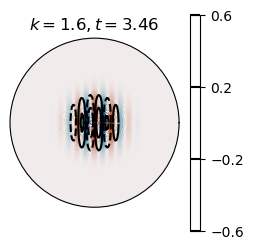

2024-04-18 12:00:49,681 __main__ 0/1 INFO :: Iteration=24, Time=3.770, dt=1.571e-01, KE=1.985e+00


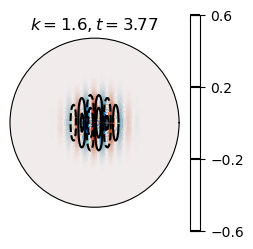

2024-04-18 12:00:50,590 __main__ 0/1 INFO :: Iteration=26, Time=4.084, dt=1.571e-01, KE=1.985e+00


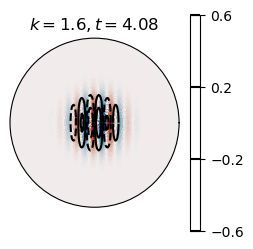

2024-04-18 12:00:51,152 __main__ 0/1 INFO :: Iteration=28, Time=4.398, dt=1.571e-01, KE=1.985e+00


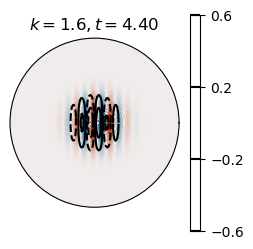

2024-04-18 12:00:51,670 __main__ 0/1 INFO :: Iteration=30, Time=4.712, dt=1.571e-01, KE=1.985e+00


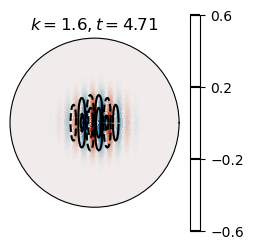

2024-04-18 12:00:52,253 __main__ 0/1 INFO :: Iteration=32, Time=5.027, dt=1.571e-01, KE=1.979e+00


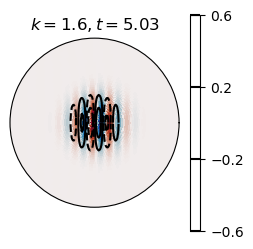

2024-04-18 12:00:52,880 __main__ 0/1 INFO :: Iteration=34, Time=5.341, dt=1.571e-01, KE=1.979e+00


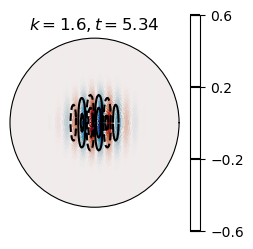

2024-04-18 12:00:53,522 __main__ 0/1 INFO :: Iteration=36, Time=5.655, dt=1.571e-01, KE=1.979e+00


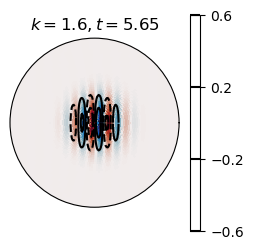

2024-04-18 12:00:54,146 __main__ 0/1 INFO :: Iteration=38, Time=5.969, dt=1.571e-01, KE=1.979e+00


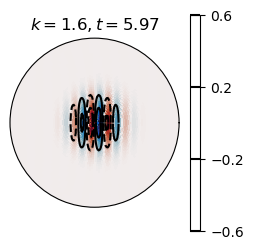

2024-04-18 12:00:54,750 __main__ 0/1 INFO :: Iteration=40, Time=6.283, dt=1.571e-01, KE=1.979e+00


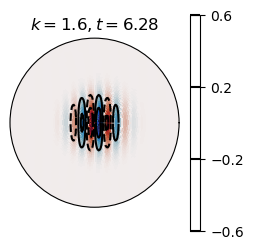

2024-04-18 12:00:55,239 __main__ 0/1 INFO :: Iteration=42, Time=6.597, dt=1.571e-01, KE=1.973e+00


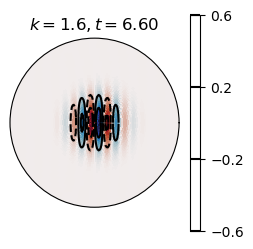

2024-04-18 12:00:55,721 __main__ 0/1 INFO :: Iteration=44, Time=6.912, dt=1.571e-01, KE=1.973e+00


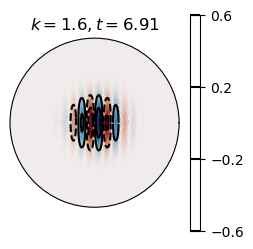

2024-04-18 12:00:56,247 __main__ 0/1 INFO :: Iteration=46, Time=7.226, dt=1.571e-01, KE=1.973e+00


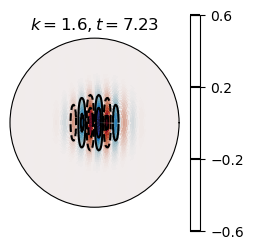

2024-04-18 12:00:56,835 __main__ 0/1 INFO :: Iteration=48, Time=7.540, dt=1.571e-01, KE=1.973e+00


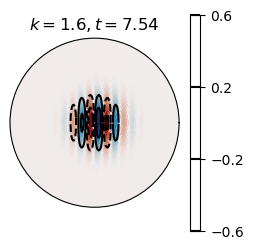

2024-04-18 12:00:57,455 __main__ 0/1 INFO :: Iteration=50, Time=7.854, dt=1.571e-01, KE=1.973e+00


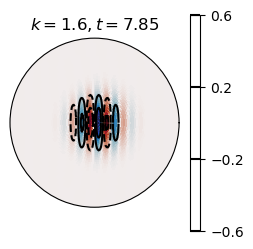

2024-04-18 12:00:58,158 __main__ 0/1 INFO :: Iteration=52, Time=8.168, dt=1.571e-01, KE=1.968e+00


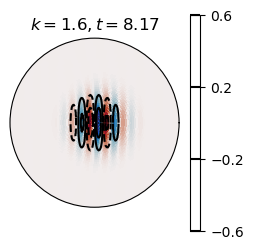

2024-04-18 12:00:58,664 __main__ 0/1 INFO :: Iteration=54, Time=8.482, dt=1.571e-01, KE=1.968e+00


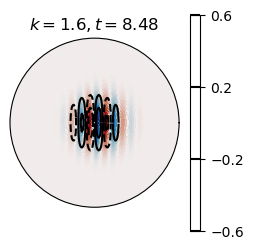

2024-04-18 12:00:59,281 __main__ 0/1 INFO :: Iteration=56, Time=8.796, dt=1.571e-01, KE=1.968e+00


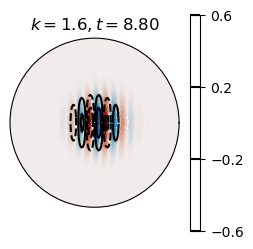

2024-04-18 12:01:00,466 __main__ 0/1 INFO :: Iteration=58, Time=9.111, dt=1.571e-01, KE=1.968e+00


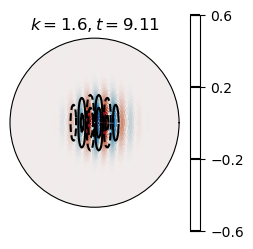

2024-04-18 12:01:02,015 __main__ 0/1 INFO :: Iteration=60, Time=9.425, dt=1.571e-01, KE=1.968e+00


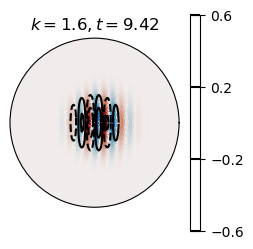

2024-04-18 12:01:03,238 __main__ 0/1 INFO :: Iteration=62, Time=9.739, dt=1.571e-01, KE=1.962e+00


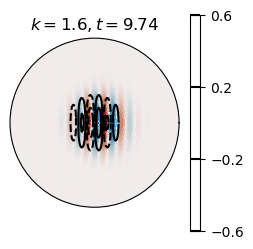

2024-04-18 12:01:04,191 __main__ 0/1 INFO :: Iteration=64, Time=10.053, dt=1.571e-01, KE=1.962e+00


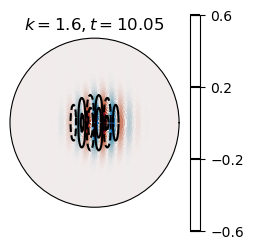

2024-04-18 12:01:05,373 __main__ 0/1 INFO :: Iteration=66, Time=10.367, dt=1.571e-01, KE=1.962e+00


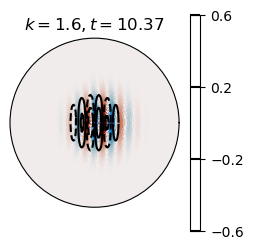

2024-04-18 12:01:06,381 __main__ 0/1 INFO :: Iteration=68, Time=10.681, dt=1.571e-01, KE=1.962e+00


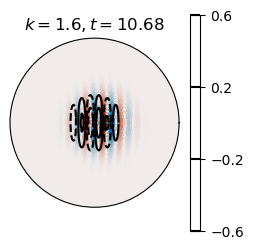

2024-04-18 12:01:07,105 __main__ 0/1 INFO :: Iteration=70, Time=10.996, dt=1.571e-01, KE=1.962e+00


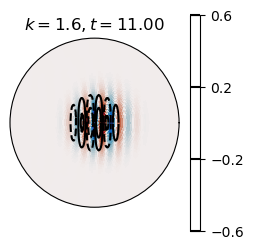

2024-04-18 12:01:07,868 __main__ 0/1 INFO :: Iteration=72, Time=11.310, dt=1.571e-01, KE=1.957e+00


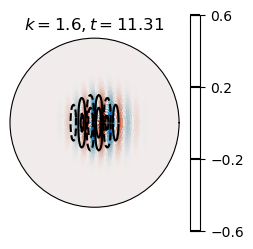

2024-04-18 12:01:08,544 __main__ 0/1 INFO :: Iteration=74, Time=11.624, dt=1.571e-01, KE=1.957e+00


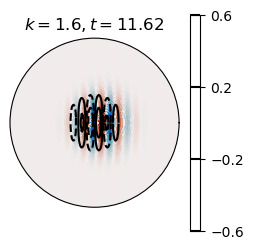

2024-04-18 12:01:09,306 __main__ 0/1 INFO :: Iteration=76, Time=11.938, dt=1.571e-01, KE=1.957e+00


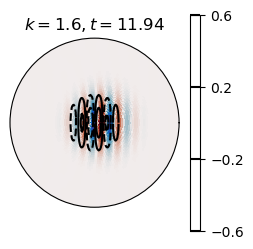

2024-04-18 12:01:10,286 __main__ 0/1 INFO :: Iteration=78, Time=12.252, dt=1.571e-01, KE=1.957e+00


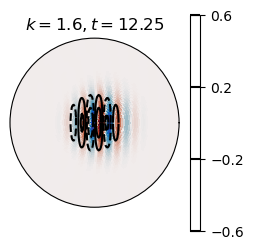

2024-04-18 12:01:11,142 __main__ 0/1 INFO :: Iteration=80, Time=12.566, dt=1.571e-01, KE=1.957e+00


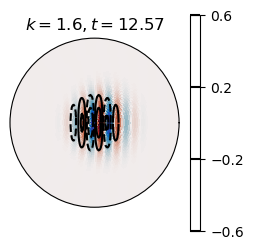

2024-04-18 12:01:11,923 __main__ 0/1 INFO :: Iteration=82, Time=12.881, dt=1.571e-01, KE=1.951e+00


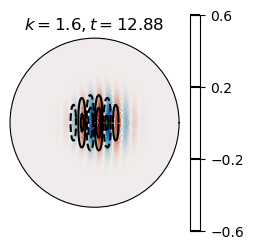

2024-04-18 12:01:12,768 __main__ 0/1 INFO :: Iteration=84, Time=13.195, dt=1.571e-01, KE=1.951e+00


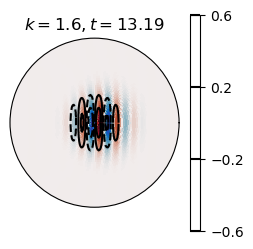

2024-04-18 12:01:13,821 __main__ 0/1 INFO :: Iteration=86, Time=13.509, dt=1.571e-01, KE=1.951e+00


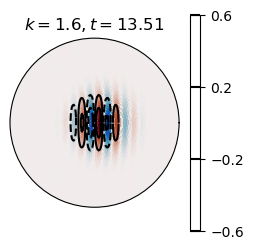

2024-04-18 12:01:14,835 __main__ 0/1 INFO :: Iteration=88, Time=13.823, dt=1.571e-01, KE=1.951e+00


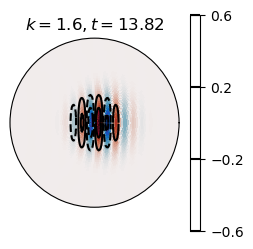

2024-04-18 12:01:15,777 __main__ 0/1 INFO :: Iteration=90, Time=14.137, dt=1.571e-01, KE=1.951e+00


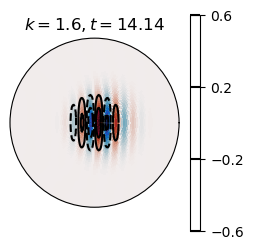

2024-04-18 12:01:16,548 __main__ 0/1 INFO :: Iteration=92, Time=14.451, dt=1.571e-01, KE=1.946e+00


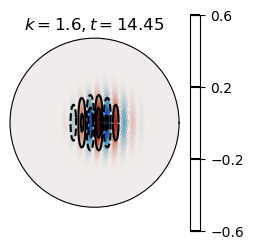

2024-04-18 12:01:17,323 __main__ 0/1 INFO :: Iteration=94, Time=14.765, dt=1.571e-01, KE=1.946e+00


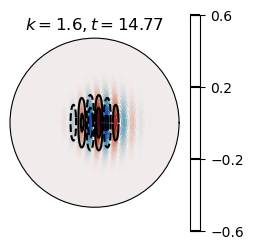

2024-04-18 12:01:18,011 __main__ 0/1 INFO :: Iteration=96, Time=15.080, dt=1.571e-01, KE=1.946e+00


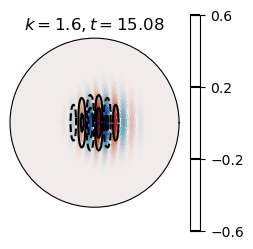

2024-04-18 12:01:18,750 __main__ 0/1 INFO :: Iteration=98, Time=15.394, dt=1.571e-01, KE=1.946e+00


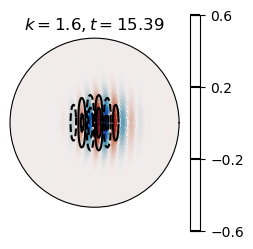

2024-04-18 12:01:19,445 __main__ 0/1 INFO :: Iteration=100, Time=15.708, dt=1.571e-01, KE=1.946e+00


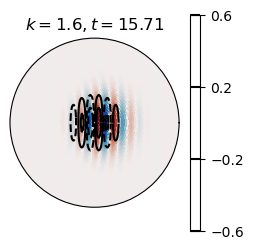

2024-04-18 12:01:20,234 __main__ 0/1 INFO :: Iteration=102, Time=16.022, dt=1.571e-01, KE=1.940e+00


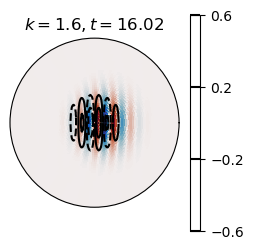

2024-04-18 12:01:21,130 __main__ 0/1 INFO :: Iteration=104, Time=16.336, dt=1.571e-01, KE=1.940e+00


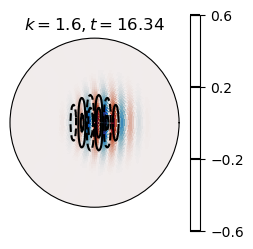

2024-04-18 12:01:21,714 __main__ 0/1 INFO :: Iteration=106, Time=16.650, dt=1.571e-01, KE=1.940e+00


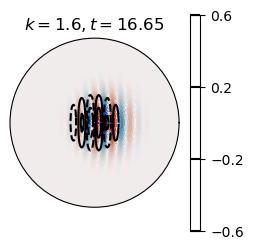

2024-04-18 12:01:22,243 __main__ 0/1 INFO :: Iteration=108, Time=16.965, dt=1.571e-01, KE=1.940e+00


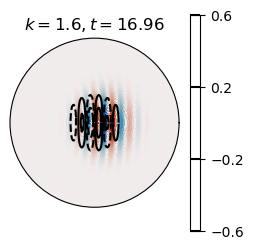

2024-04-18 12:01:22,766 __main__ 0/1 INFO :: Iteration=110, Time=17.279, dt=1.571e-01, KE=1.940e+00


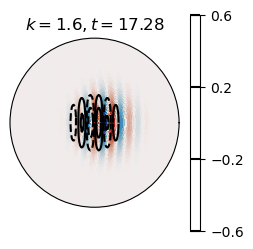

2024-04-18 12:01:23,378 __main__ 0/1 INFO :: Iteration=112, Time=17.593, dt=1.571e-01, KE=1.935e+00


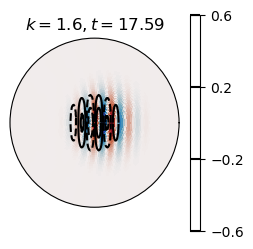

2024-04-18 12:01:24,171 __main__ 0/1 INFO :: Iteration=114, Time=17.907, dt=1.571e-01, KE=1.935e+00


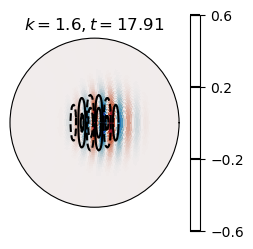

2024-04-18 12:01:24,865 __main__ 0/1 INFO :: Iteration=116, Time=18.221, dt=1.571e-01, KE=1.935e+00


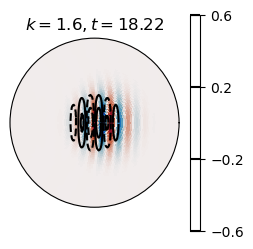

2024-04-18 12:01:25,482 __main__ 0/1 INFO :: Iteration=118, Time=18.535, dt=1.571e-01, KE=1.935e+00


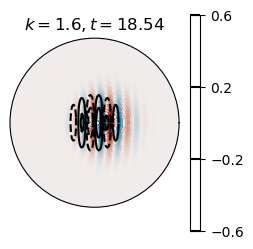

2024-04-18 12:01:26,216 __main__ 0/1 INFO :: Iteration=120, Time=18.850, dt=1.571e-01, KE=1.935e+00


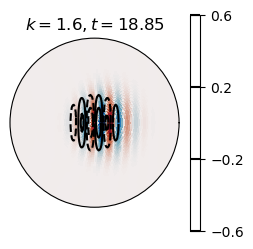

2024-04-18 12:01:27,194 __main__ 0/1 INFO :: Iteration=122, Time=19.164, dt=1.571e-01, KE=1.929e+00


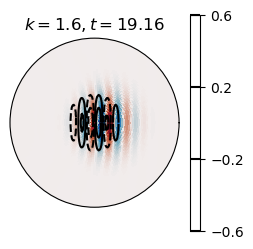

2024-04-18 12:01:28,000 __main__ 0/1 INFO :: Iteration=124, Time=19.478, dt=1.571e-01, KE=1.929e+00


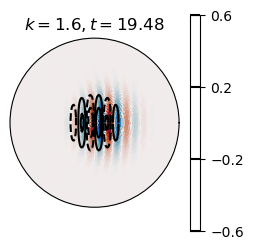

2024-04-18 12:01:28,676 __main__ 0/1 INFO :: Iteration=126, Time=19.792, dt=1.571e-01, KE=1.929e+00


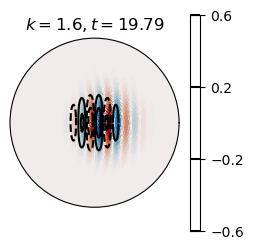

2024-04-18 12:01:29,333 __main__ 0/1 INFO :: Iteration=128, Time=20.106, dt=1.571e-01, KE=1.929e+00


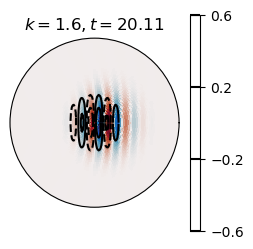

2024-04-18 12:01:30,066 __main__ 0/1 INFO :: Iteration=130, Time=20.420, dt=1.571e-01, KE=1.929e+00


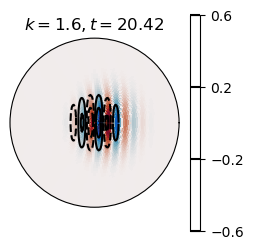

2024-04-18 12:01:30,619 __main__ 0/1 INFO :: Iteration=132, Time=20.735, dt=1.571e-01, KE=1.924e+00


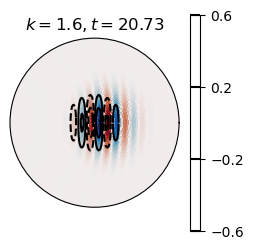

2024-04-18 12:01:31,218 __main__ 0/1 INFO :: Iteration=134, Time=21.049, dt=1.571e-01, KE=1.924e+00


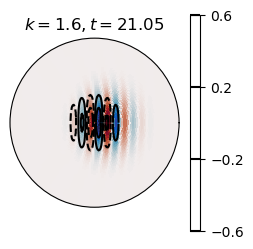

2024-04-18 12:01:31,893 __main__ 0/1 INFO :: Iteration=136, Time=21.363, dt=1.571e-01, KE=1.924e+00


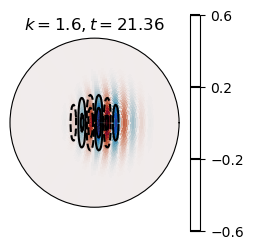

2024-04-18 12:01:32,471 __main__ 0/1 INFO :: Iteration=138, Time=21.677, dt=1.571e-01, KE=1.924e+00


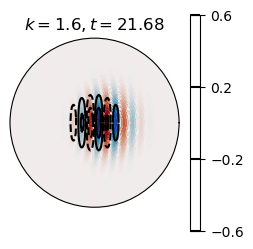

2024-04-18 12:01:33,007 __main__ 0/1 INFO :: Iteration=140, Time=21.991, dt=1.571e-01, KE=1.924e+00


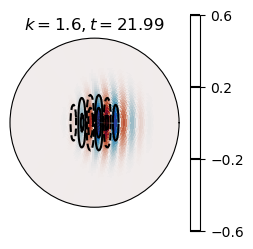

2024-04-18 12:01:33,542 __main__ 0/1 INFO :: Iteration=142, Time=22.305, dt=1.571e-01, KE=1.918e+00


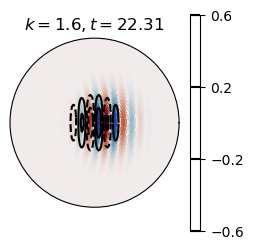

2024-04-18 12:01:34,015 __main__ 0/1 INFO :: Iteration=144, Time=22.619, dt=1.571e-01, KE=1.918e+00


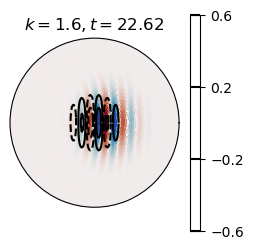

2024-04-18 12:01:34,516 __main__ 0/1 INFO :: Iteration=146, Time=22.934, dt=1.571e-01, KE=1.918e+00


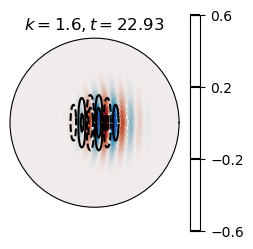

2024-04-18 12:01:35,146 __main__ 0/1 INFO :: Iteration=148, Time=23.248, dt=1.571e-01, KE=1.918e+00


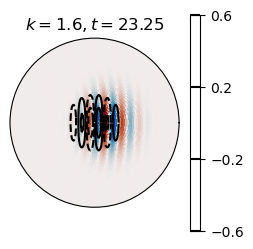

2024-04-18 12:01:36,033 __main__ 0/1 INFO :: Iteration=150, Time=23.562, dt=1.571e-01, KE=1.918e+00


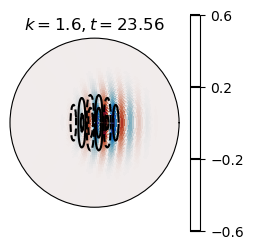

2024-04-18 12:01:36,836 __main__ 0/1 INFO :: Iteration=152, Time=23.876, dt=1.571e-01, KE=1.913e+00


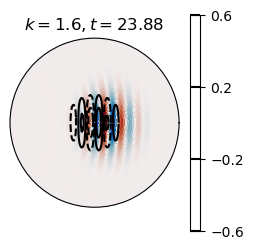

2024-04-18 12:01:37,456 __main__ 0/1 INFO :: Iteration=154, Time=24.190, dt=1.571e-01, KE=1.913e+00


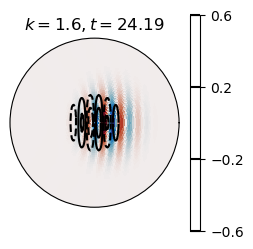

2024-04-18 12:01:38,049 __main__ 0/1 INFO :: Iteration=156, Time=24.504, dt=1.571e-01, KE=1.913e+00


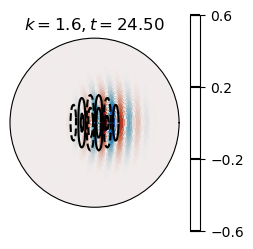

2024-04-18 12:01:38,583 __main__ 0/1 INFO :: Iteration=158, Time=24.819, dt=1.571e-01, KE=1.913e+00


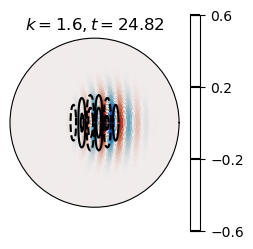

2024-04-18 12:01:39,167 __main__ 0/1 INFO :: Iteration=160, Time=25.133, dt=1.571e-01, KE=1.913e+00


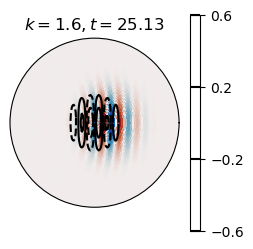

2024-04-18 12:01:39,895 __main__ 0/1 INFO :: Iteration=162, Time=25.447, dt=1.571e-01, KE=1.908e+00


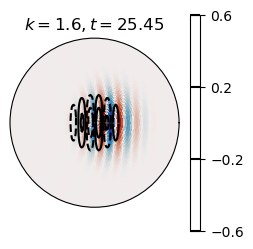

2024-04-18 12:01:40,549 __main__ 0/1 INFO :: Iteration=164, Time=25.761, dt=1.571e-01, KE=1.908e+00


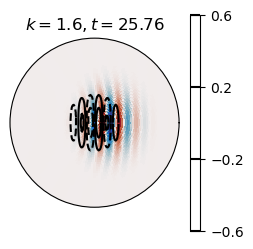

2024-04-18 12:01:41,214 __main__ 0/1 INFO :: Iteration=166, Time=26.075, dt=1.571e-01, KE=1.908e+00


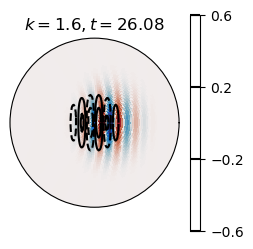

2024-04-18 12:01:41,800 __main__ 0/1 INFO :: Iteration=168, Time=26.389, dt=1.571e-01, KE=1.908e+00


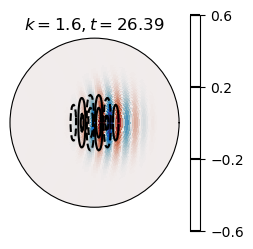

2024-04-18 12:01:42,303 __main__ 0/1 INFO :: Iteration=170, Time=26.704, dt=1.571e-01, KE=1.908e+00


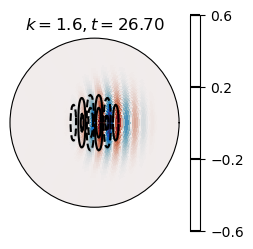

2024-04-18 12:01:42,847 __main__ 0/1 INFO :: Iteration=172, Time=27.018, dt=1.571e-01, KE=1.902e+00


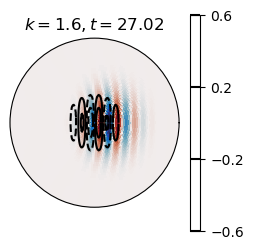

2024-04-18 12:01:43,488 __main__ 0/1 INFO :: Iteration=174, Time=27.332, dt=1.571e-01, KE=1.902e+00


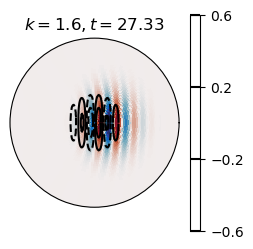

2024-04-18 12:01:44,241 __main__ 0/1 INFO :: Iteration=176, Time=27.646, dt=1.571e-01, KE=1.902e+00


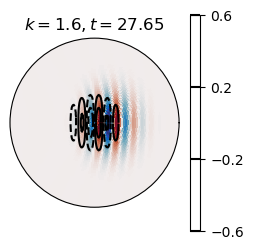

2024-04-18 12:01:44,905 __main__ 0/1 INFO :: Iteration=178, Time=27.960, dt=1.571e-01, KE=1.902e+00


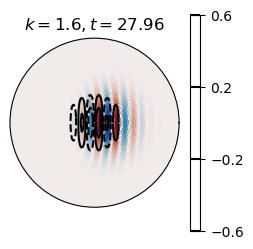

2024-04-18 12:01:45,653 __main__ 0/1 INFO :: Iteration=180, Time=28.274, dt=1.571e-01, KE=1.902e+00


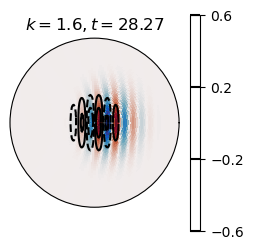

2024-04-18 12:01:46,338 __main__ 0/1 INFO :: Iteration=182, Time=28.588, dt=1.571e-01, KE=1.897e+00


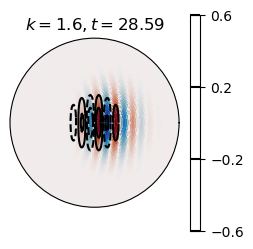

2024-04-18 12:01:46,861 __main__ 0/1 INFO :: Iteration=184, Time=28.903, dt=1.571e-01, KE=1.897e+00


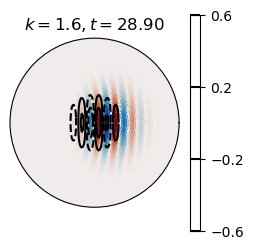

2024-04-18 12:01:47,545 __main__ 0/1 INFO :: Iteration=186, Time=29.217, dt=1.571e-01, KE=1.897e+00


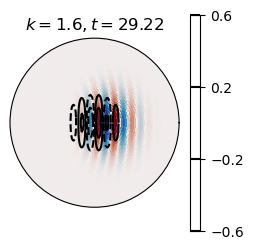

2024-04-18 12:01:48,120 __main__ 0/1 INFO :: Iteration=188, Time=29.531, dt=1.571e-01, KE=1.897e+00


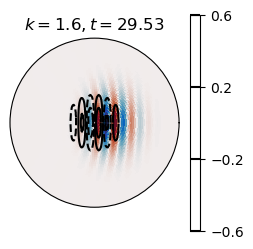

2024-04-18 12:01:48,623 __main__ 0/1 INFO :: Iteration=190, Time=29.845, dt=1.571e-01, KE=1.897e+00


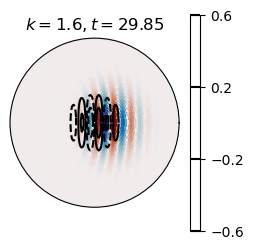

2024-04-18 12:01:49,166 __main__ 0/1 INFO :: Iteration=192, Time=30.159, dt=1.571e-01, KE=1.891e+00


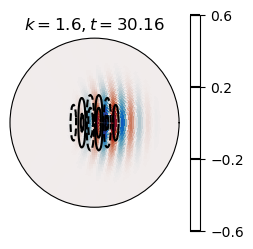

2024-04-18 12:01:49,631 __main__ 0/1 INFO :: Iteration=194, Time=30.473, dt=1.571e-01, KE=1.891e+00


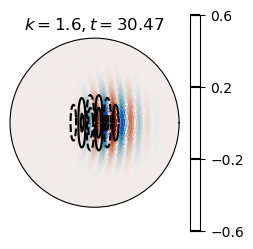

2024-04-18 12:01:50,206 __main__ 0/1 INFO :: Iteration=196, Time=30.788, dt=1.571e-01, KE=1.891e+00


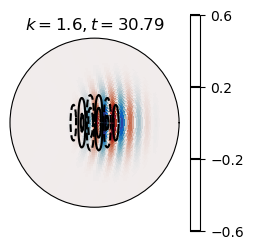

2024-04-18 12:01:50,756 __main__ 0/1 INFO :: Iteration=198, Time=31.102, dt=1.571e-01, KE=1.891e+00


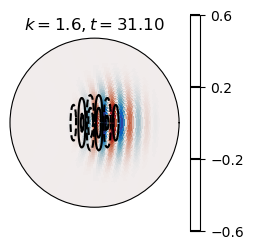

2024-04-18 12:01:51,414 __main__ 0/1 INFO :: Iteration=200, Time=31.416, dt=1.571e-01, KE=1.891e+00


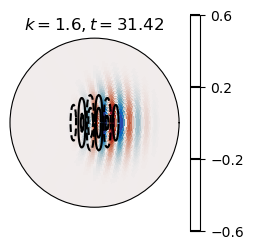

2024-04-18 12:01:52,058 __main__ 0/1 INFO :: Iteration=202, Time=31.730, dt=1.571e-01, KE=1.886e+00


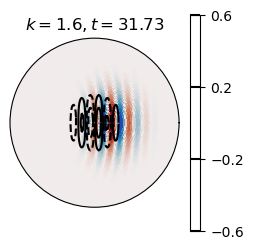

2024-04-18 12:01:52,598 __main__ 0/1 INFO :: Iteration=204, Time=32.044, dt=1.571e-01, KE=1.886e+00


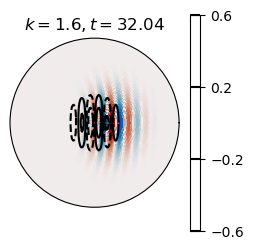

2024-04-18 12:01:53,119 __main__ 0/1 INFO :: Iteration=206, Time=32.358, dt=1.571e-01, KE=1.886e+00


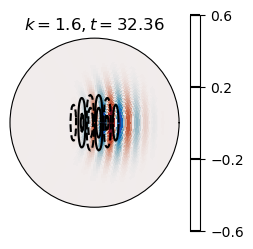

2024-04-18 12:01:53,696 __main__ 0/1 INFO :: Iteration=208, Time=32.673, dt=1.571e-01, KE=1.886e+00


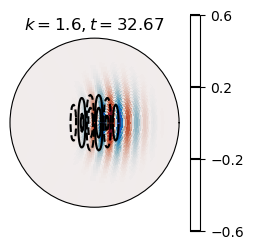

2024-04-18 12:01:54,296 __main__ 0/1 INFO :: Iteration=210, Time=32.987, dt=1.571e-01, KE=1.886e+00


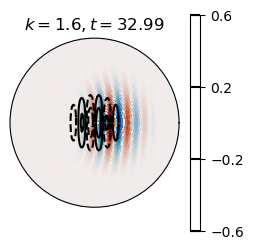

2024-04-18 12:01:55,262 __main__ 0/1 INFO :: Iteration=212, Time=33.301, dt=1.571e-01, KE=1.881e+00


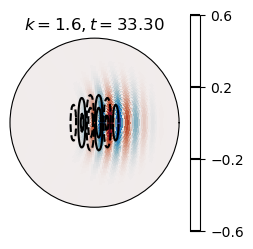

2024-04-18 12:01:56,036 __main__ 0/1 INFO :: Iteration=214, Time=33.615, dt=1.571e-01, KE=1.881e+00


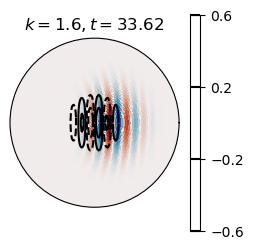

2024-04-18 12:01:56,688 __main__ 0/1 INFO :: Iteration=216, Time=33.929, dt=1.571e-01, KE=1.881e+00


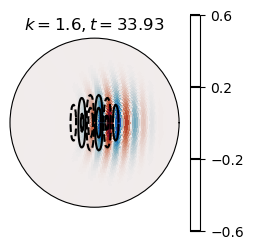

2024-04-18 12:01:57,224 __main__ 0/1 INFO :: Iteration=218, Time=34.243, dt=1.571e-01, KE=1.881e+00


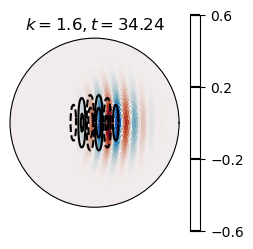

2024-04-18 12:01:57,694 __main__ 0/1 INFO :: Iteration=220, Time=34.558, dt=1.571e-01, KE=1.881e+00


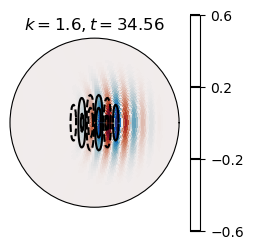

2024-04-18 12:01:58,206 __main__ 0/1 INFO :: Iteration=222, Time=34.872, dt=1.571e-01, KE=1.876e+00


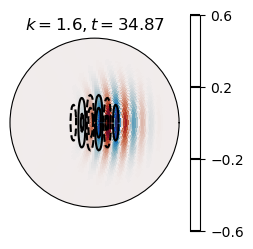

2024-04-18 12:01:58,845 __main__ 0/1 INFO :: Iteration=224, Time=35.186, dt=1.571e-01, KE=1.876e+00


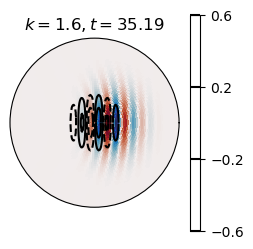

2024-04-18 12:01:59,445 __main__ 0/1 INFO :: Iteration=226, Time=35.500, dt=1.571e-01, KE=1.876e+00


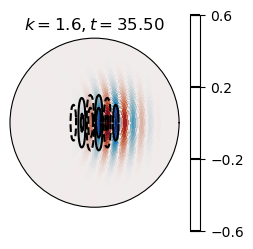

2024-04-18 12:01:59,994 __main__ 0/1 INFO :: Iteration=228, Time=35.814, dt=1.571e-01, KE=1.876e+00


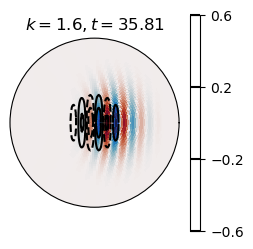

2024-04-18 12:02:00,692 __main__ 0/1 INFO :: Iteration=230, Time=36.128, dt=1.571e-01, KE=1.876e+00


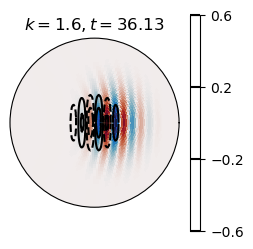

2024-04-18 12:02:01,439 __main__ 0/1 INFO :: Iteration=232, Time=36.442, dt=1.571e-01, KE=1.870e+00


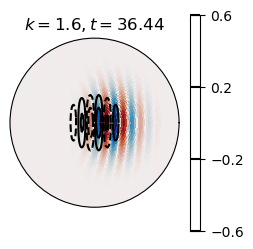

2024-04-18 12:02:02,284 __main__ 0/1 INFO :: Iteration=234, Time=36.757, dt=1.571e-01, KE=1.870e+00


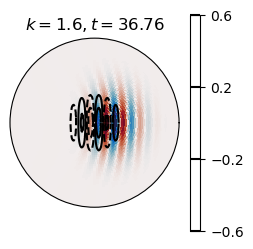

2024-04-18 12:02:03,096 __main__ 0/1 INFO :: Iteration=236, Time=37.071, dt=1.571e-01, KE=1.870e+00


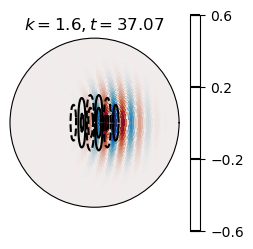

2024-04-18 12:02:04,116 __main__ 0/1 INFO :: Iteration=238, Time=37.385, dt=1.571e-01, KE=1.870e+00


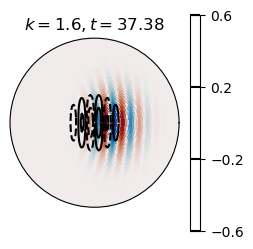

2024-04-18 12:02:04,858 __main__ 0/1 INFO :: Iteration=240, Time=37.699, dt=1.571e-01, KE=1.870e+00


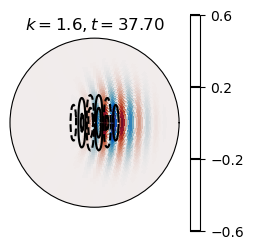

2024-04-18 12:02:05,650 __main__ 0/1 INFO :: Iteration=242, Time=38.013, dt=1.571e-01, KE=1.865e+00


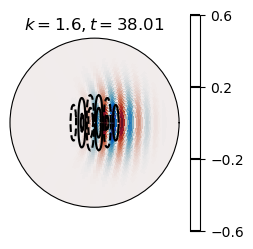

2024-04-18 12:02:06,564 __main__ 0/1 INFO :: Iteration=244, Time=38.327, dt=1.571e-01, KE=1.865e+00


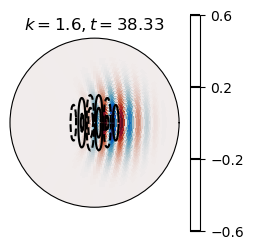

2024-04-18 12:02:07,630 __main__ 0/1 INFO :: Iteration=246, Time=38.642, dt=1.571e-01, KE=1.865e+00


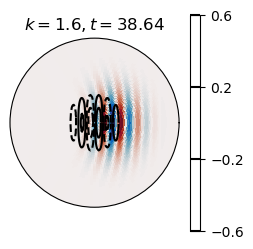

2024-04-18 12:02:08,621 __main__ 0/1 INFO :: Iteration=248, Time=38.956, dt=1.571e-01, KE=1.865e+00


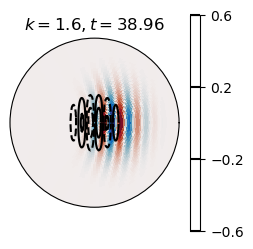

2024-04-18 12:02:09,462 __main__ 0/1 INFO :: Iteration=250, Time=39.270, dt=1.571e-01, KE=1.865e+00


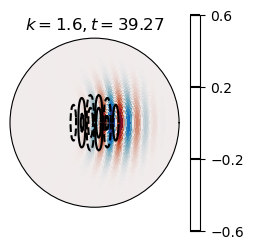

2024-04-18 12:02:10,531 __main__ 0/1 INFO :: Iteration=252, Time=39.584, dt=1.571e-01, KE=1.860e+00


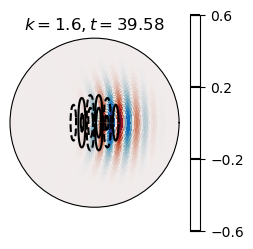

2024-04-18 12:02:11,558 __main__ 0/1 INFO :: Iteration=254, Time=39.898, dt=1.571e-01, KE=1.860e+00


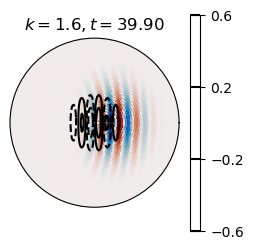

2024-04-18 12:02:12,263 solvers 0/1 INFO :: Simulation stop time reached.
2024-04-18 12:02:12,264 solvers 0/1 INFO :: Final iteration: 255
2024-04-18 12:02:12,265 solvers 0/1 INFO :: Final sim time: 40.05530633327004
2024-04-18 12:02:12,265 solvers 0/1 INFO :: Setup time (init - iter 0): 3.09 sec
2024-04-18 12:02:12,266 solvers 0/1 INFO :: Warmup time (iter 0-10): 5.424 sec
2024-04-18 12:02:12,267 solvers 0/1 INFO :: Run time (iter 10-end): 86.68 sec
2024-04-18 12:02:12,268 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02408 cpu-hr
2024-04-18 12:02:12,269 solvers 0/1 INFO :: Speed: 1.404e+05 mode-stages/cpu-sec


In [8]:
# Main loop
# Main loop
timestep = np.pi/20
delr = R/Nr
try:
    logger.info('Starting main loop')
    solver.step(timestep)
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % dt_change_freq == 0:
            maxU = max(1e-10,np.sqrt(flow.max('absuv')))
            
        if (solver.iteration) % 2 == 0:
            KE_prop = flow.volume_integral('KE')
            logger.info('Iteration=%i, Time=%.3f, dt=%.3e, KE=%.3e' %(solver.iteration, solver.sim_time, timestep, KE_prop))

            fig = plt.figure(figsize=(15/2.5, 7/2.5))

            q.change_scales(1), q_IC.change_scales(1)
            ax = fig.add_subplot(121, polar=True); ax.grid(False); plt.xticks([]); plt.yticks([]) 
            pc = ax.pcolormesh(th.T,r.T,q['g'].T, cmap=cmo.balance, norm=colors.CenteredNorm())
            pc = ax.contour(r_mat,theta_mat,q_IC['g'].T,[-0.6,-0.2,0.2,0.6], colors='black')
            fig.colorbar(pc); 
            plt.title("$k = %.1f, t=%.2f$" %(Rosswave_k, solver.sim_time))

            if solver.sim_time<10:
                figname = 'video_plot/Rossby_k%.1f_t%.2f' %(Rosswave_k, solver.sim_time)
                figname = figname.replace(".", "d" ); figname = figname+'.png'
            else:
                figname = 'video_plot/Rossby_k%.1f_tt%.2f' %(Rosswave_k, solver.sim_time)
                figname = figname.replace(".", "d" ); figname = figname+'.png'
            plt.savefig(figname, bbox_inches='tight', dpi=400)
            plt.show()

except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()